# Face Detection Project: Model Training

This is the training notebook for the Face Detection Project. In this notebook we create a model to detect faces in images. Once created, the model is saved to a file for later use.
The request is to create a sklearn pipeline that includes a feature extractor and a classifier, and return a list of bounding boxes for the detected faces. If no faces are detected, the function should return an empty list.

In [1]:
import process as pc
import dataset as ds
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
import cv2
import gc

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

## Data
In order to create the model, we selected two data sources:
- The [Flickr-Faces Dataset (Nvidia) 128x128](https://www.kaggle.com/datasets/dullaz/flickrfaces-dataset-nvidia-128x128) dataset, which contains 70,000 images of faces.
- The [Caltech-101](https://data.caltech.edu/records/mzrjq-6wc02) dataset, which contains 8,275 images of 101 classes of objects.<br>
- The [Landscape Dataset](https://www.kaggle.com/datasets/arnaud58/landscape-pictures) dataset, which contains 4,319 images of landscapes.

The Caltech dataset is used to create a negative dataset, by cropping random patches from the images. The negative dataset is used to train the model to detect faces in images, in order to avoid false positives, and improve the model's performance.

In [2]:
positive_images_path = ds.DATA_PATH+"/real_faces_128"
negative_images_path = ds.DATA_PATH+"/caltech-101/101_ObjectCategories"

ds.extract_dataset(positive_images_path)
bad_imgs_path_list = ds.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


One of the requirements provided is that the model should be trained on a system with a reduced computing capacity, the model should require low computational resources, and the training should be done in a reasonable amount of time. For this reason, *we will use a small subset of the data to train the model*.<br>
In particular we will use a dataset of **19500 images from the Flickr-Faces Dataset**, and **22000 images from the Caltech-101 + Landscape dataset**. Since, as we already said, the negative dataset has just 12594 images, we needed to augment the quantity of "negative" (negative for our purpose) images. In one of the next steps we will analyse the technique we exploited.<br>
We will also try to adopt some strategies to reduce the amount of memory required by the model, however, **a PC with 32 GB RAM and 2 GB swap may be required to run this notebook**. 

In [3]:
n_good_images = 19500
n_bad_images_folder=15000
size_w = size_h = 96

#count bad images:
bad_img_list = set()
for fld in bad_imgs_path_list:
    tmp_img_list = ds.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    for img in tmp_img_list:
        img_path = negative_images_path+"/"+fld+'/'+img
        bad_img_list.add(img_path)

len(bad_img_list)

/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


12594

In order to augment the number of negative images, we will use the following technique:
- We will crop random patches from the images in the negative dataset, and we will use them as negative samples. After the crop we reshape them to match the size of the positive samples.
- The other strategy is to rotate the images by 90, 180 and 270 degrees, and use them as negative samples.<br>
In such a way we obtain 22000 negative samples.

In [4]:
bad_patches = ds.extract_patches(bad_img_list, (size_w, size_h), n_patches=22000, random_seed=7)
len(bad_patches)
img_list = ds.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
dataset = np.empty((n_good_images+len(bad_patches), size_w, size_h), dtype=np.uint8)
good_img_len = 0

22000

## Feature Extraction Techniques
We will use the Histogram of Oriented Gradients (HOG) feature extraction technique to extract features from the images. The HOG technique is used to detect objects in images, and is particularly useful for detecting faces. The HOG technique works by dividing the image into small cells, and calculating the gradient of each cell. The gradients are then used to create a histogram of the orientations of the gradients. The histograms are then normalized, and concatenated to create a feature vector for the image.<br>
Other two feature techinques we explored was Scale Invariant Features Transform (SIFT) and Oriented Fast and Rotated Brief (ORB). The SIFT technique is used to detect and describe local features in images, and is particularly useful for object recognition. The ORB technique is used to detect and describe keypoints in images, and is particularly useful for object detection. However, we found that the HOG technique performed better than the other two techniques, and we decided to use it for the model.<br>
Even if they are no more used, the code for the other two techniques is still present in the project, since we think it could be useful for future improvements.

In [5]:
choices = ['HOG', 'SIFT', 'ORB']
print("Choose feature extractor:", flush=True)
for i, choice in enumerate(choices):
    print("{}. {}".format(i+1, choice), flush=True)
#print("%s" %(["%d. %s" %(i+1, choice) for i, choice in enumerate(choices)]), flush=True)

choice_features_extractor = str(input())
choice_features_extractor= choice_features_extractor.upper()
idx = None
while 1:
    if choice_features_extractor == 'HOG':
        idx = choices.index(choice_features_extractor.upper())+1
        break
    elif choice_features_extractor in choices:
        print("Warning: %s not implemented yet. We apologize for the inconvenience." %choice_features_extractor)
    else:
        print("Invalid choice\n")
print("You chose: {}. {}".format(idx, choice_features_extractor.upper()), flush=True)

Choose feature extractor:
1. HOG
2. SIFT
3. ORB
You chose: 1. HOG


We dedice to preprocess the images before extracting the features, in order to reduce the amount of memory required by the model. In particular, we will resize the images to 96x96 pixels, and convert them to grayscale. We will also normalize the pixel values to be between 0 and 1. We optionally apply a Gaussian blur to the images, in order to reduce the noise in the images, and we equalize the histogram of the images, in order to improve the contrast of the images.
In one of the attempts we also tried to apply an adaptive threshold to the images, in order to improve the contrast of the images, but we found that it did not improve the performance of the model, and we decided not to use it, keeping it as optional.<br>
In case of positive samples, we had an observation to make: since the harware we used was relatively limited, we had to decide if we wanted to use a dataset with a lot of different faces and brightness conditions, or if we wanted to limit the number of faces, and enlarge the dataset by applying some transformations. <br> 
We decided to use the first approach, since we think that the variety of faces is a key factor in the performance of the model. The limit of this approach could be that the model could have more difficulties in detecting faces in images with different sizes.

In [6]:
for i, img in enumerate(img_list):
    image = cv2.imread(ds.DATA_PATH+"/real_faces_128/"+img)
    dataset[i, ...] = pc.process_image(image, resize=True, img_resize=(size_w, size_h), denoise=True)
    good_img_len += 1

for i, img in zip(range(len(bad_patches)), bad_patches):
    dataset[good_img_len+i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h), denoise=True)

In [7]:
del tmp_img_list, img_list, bad_img_list, bad_patches
gc.collect()

0

Here we have a sample of the images we used for the training:

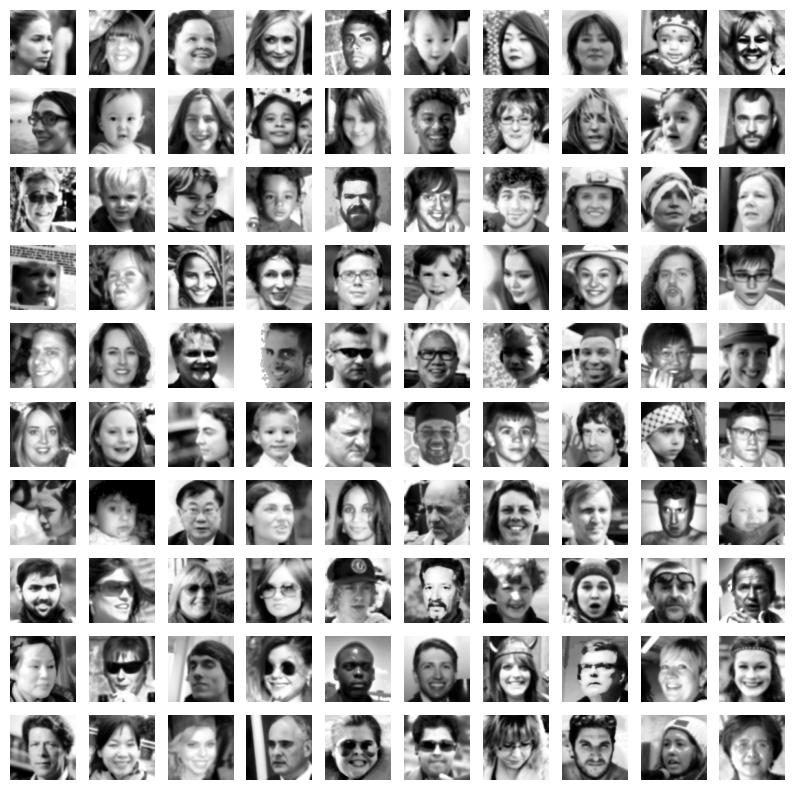

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

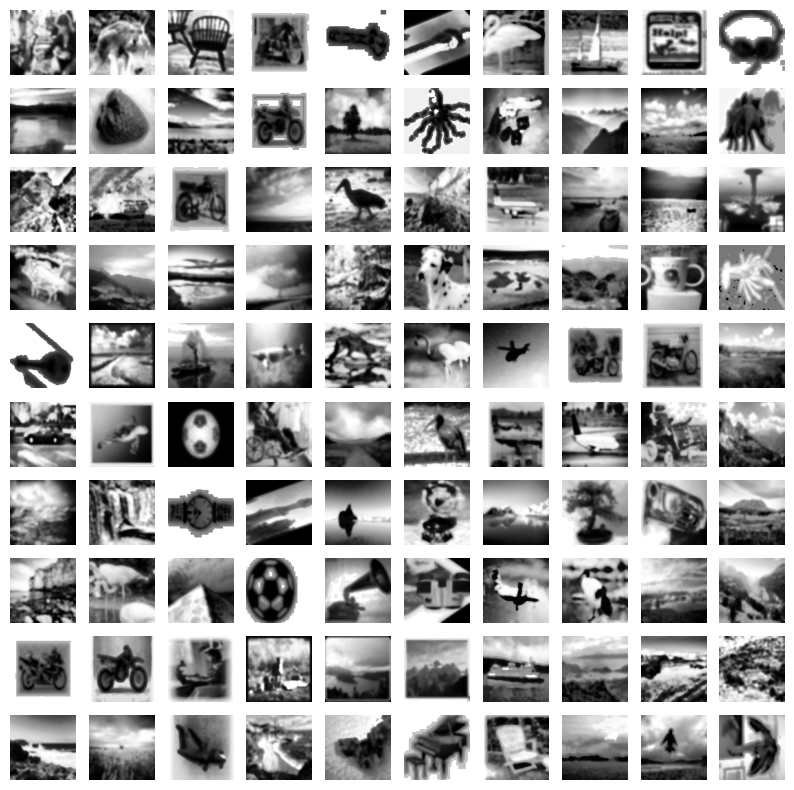

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[good_img_len+i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

In [10]:
dataset.shape

(41500, 96, 96)

We then extract the HOG features, exploiting the `hog` function from the `skimage.feature` module. We use the default parameters for the function, which are:
- `orientations=9`: the number of orientation bins.
- `pixels_per_cell=(8, 8)`: the size of the cells in pixels.
- `cells_per_block=(3, 3)`: the size of the blocks in cells.
- `block_norm='L2-Hys'`: the block normalization method.


In [11]:
good_samples = n_good_images
bad_samples = dataset.shape[0] - good_samples
n_keypoints = 32
n_features = 128
ftr_shape = n_keypoints*n_features
if choice_features_extractor == "HOG":
   ftr_shape = 8100
   
features = None
X = np.empty((good_samples+bad_samples, ftr_shape), dtype=np.float64)
l = 0

for i, img in enumerate(dataset):
   if choice_features_extractor == "ORB":
      _, features = pc.extract_ORB_features(img, n_keypoints=32)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "SIFT":
      kp, features = pc.extract_SIFT_features(img, n_optimal_keypoints=n_keypoints)
      if len(kp) < n_keypoints:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "HOG":
      ftr_shape = 8100
      features = pc.extract_HOG_features(img)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
      
   features = features.flatten()
   if features.shape[0] == ftr_shape:
      X[l, ...] = features
      l += 1 
   else:
      if i < good_samples:
         features.shape
         print("good sample")
         good_samples -= 1
      else:
         print("bad sample")
         bad_samples -= 1

In [12]:
good_samples
bad_samples
if l < good_samples+bad_samples:
    X = X[:l, ...]
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

19500

22000

(41500, 8100)

(41500,)

## Training the Model

Then we split the data into training and testing sets, and we train the model using the training set. We use a Support Vector Machine (SVM) classifier to train the model, since it is a powerful classifier that works well with the HOG features. We use the `LinearSVC` class from the `sklearn.svm` module. We apply a fine tuning of the parameters of the SVM, in order to improve the performance of the model using `GridSearchCV` class from the `sklearn.model_selection` module to perform a grid search over the parameters of the SVM, and find the best parameters for the model. We use the following parameters for the grid search:
- `C`: the regularization parameter.
- `max_iter`: the maximum number of iterations to run.
- `dual`: whether to use the dual or primal formulation.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [14]:
del X, y
gc.collect()

167946

In [15]:
X_train.shape
y_train.shape
X_train[0]
y_train[0]


(33200, 8100)

(33200,)

array([0.02607727, 0.03943247, 0.06275013, ..., 0.        , 0.00725587,
       0.        ])

0.0

In [16]:
param_grid = {  'C' : [np.power(10., i) for i in range(-2, 2)],
                'max_iter' : [5000],
                'random_state' : [7],
                'dual' : ['auto']
             }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=4)
grid_searh.fit(X_train, y_train)
grid_searh.best_params_

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'dual': ['auto'],
                         'max_iter': [5000], 'random_state': [7]})

{'C': 0.01, 'dual': 'auto', 'max_iter': 5000, 'random_state': 7}

Let see the accuracy of the model on the test set:

In [17]:
best_svc = grid_searh.best_estimator_

y_pred = best_svc.predict(X_train)
accuracy = round(accuracy_score(y_train, y_pred), 3)
print("Accuracy train:", accuracy)

y_pred_test = best_svc.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred_test), 3)
print("Accuracy test:", accuracy)

Accuracy train: 0.999
Accuracy test: 0.997


## Saving the Model

Finally, we save the model to a file using the `joblib.dump` function from the `joblib` module. The model is saved to a file named `model.pkl`.
We save the pipeline containing the steps of the model, in order to be able to use it in the future.

In [18]:
pipeline_save_path = ds.DATA_PATH+"/model.pkl"

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('normalize', scaler),
        ('extract_features', pc.extract_HOG_features),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )

['../data/hog_definitive_denoise.pkl']